<a href="https://colab.research.google.com/github/Jming9638/MachineLearning/blob/main/RFM_and_KMeans_Clustering_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.display import clear_output

!pip install lifetimes dataframe-image sweetviz

clear_output()

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dataframe_image as dfi
import seaborn as sns
from scipy.stats import skew
from datetime import datetime
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def custom_format(x):
    if x == int(x):
        return '{:.0f}'.format(x)
    else:
        return '{:.4f}'.format(x)
pd.set_option('display.float_format', custom_format)
sns.set_style('darkgrid')

In [ ]:
dir_path = './drive/MyDrive/ZUS_RFM_Clustering/'
f1 = 'rfm_order_level1.csv'
f2 = 'rfm_order_level2.csv'
col_name = ['order_id', 'sales_date', 'user_id', 'revenue']

df1 = pd.read_csv(dir_path + f1, names=col_name)
df2 = pd.read_csv(dir_path + f2, names=col_name)
data = pd.concat([df1, df2], ignore_index=False)
data

,order_id,sales_date,user_id,revenue
0,4069445,2022-11-04,1029960,15.4500
1,2095862,2022-04-28,705217,42.1000
2,1384764,2022-01-21,415299,21
3,7782480,2023-08-17,1965086,16.5000
4,2944170,2022-07-21,671251,36.8000
...,...,...,...,...
3950273,748774,2021-10-05,269903,26.7000
3950274,3813836,2022-10-08,840068,10.9500
3950275,2372478,2022-05-27,635526,12.6000
3950276,6642534,2023-06-17,1714975,21.8000


In [ ]:
data = data.astype({
    'order_id': 'str',
    'user_id': 'str'
})
data['sales_date'] = pd.to_datetime(data['sales_date'])

In [ ]:
def count_distinct(series):
    return len(series.unique())

min_purchased_date = min(data['sales_date'])
max_purchased_date = max(data['sales_date'])
print(f'Date range: {min_purchased_date} - {max_purchased_date}')

rfm = data.groupby(['user_id']).agg(
    first_purchase_date=('sales_date', 'min'),
    last_purchase_date=('sales_date', 'max'),
    T=('sales_date', lambda x: (max_purchased_date - x.min()).days),
    recency=('sales_date', lambda x: (max_purchased_date - x.max()).days),
    frequency=('order_id', count_distinct),
    monetary=('revenue', 'sum')
)
rfm['return_status'] = rfm.apply(
    lambda x: 'one_time' if x['first_purchase_date'] == x['last_purchase_date'] else 'return', axis=1
)
rfm['duration'] = rfm['T'] - rfm['recency']
rfm

Date range: 2021-10-01 00:00:00 - 2023-09-30 00:00:00


,first_purchase_date,last_purchase_date,T,recency,frequency,monetary,return_status,duration
user_id,,,,,,,,
1000,2021-11-17,2022-04-20,682,528,6,100.6000,return,154
100000,2022-01-25,2023-05-20,613,133,9,415.7500,return,480
1000000,2022-08-15,2022-12-11,411,293,2,54.4000,return,118
1000001,2022-08-15,2022-08-15,411,411,1,27.7500,one_time,0
1000004,2022-08-15,2022-08-20,411,406,2,59.4500,return,5
...,...,...,...,...,...,...,...,...
999992,2023-05-03,2023-08-20,150,41,2,43.5000,return,109
999994,2022-08-31,2022-09-29,395,366,2,54.4500,return,29
999997,2023-08-20,2023-09-10,41,20,2,25.8000,return,21


In [ ]:
rfm.to_csv(dir_path + 'results/rfm_summary.csv', index=True)

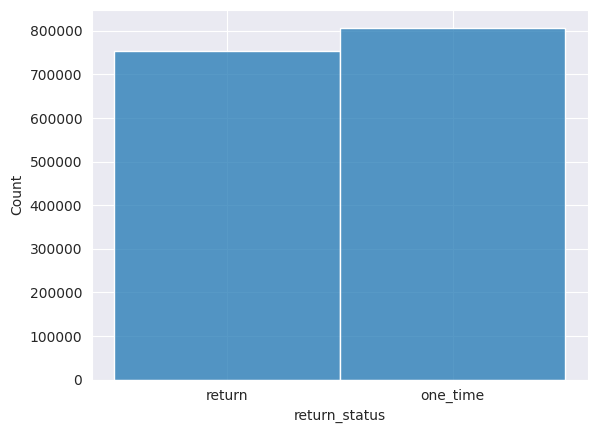

In [ ]:
sns.histplot(x=rfm['return_status'])
plt.show()

In [ ]:
# import sweetviz as sv

# report = sv.analyze(dist_data)
# report.show_html('report.html')

In [ ]:
rfm[['T', 'recency', 'duration', 'frequency', 'monetary']].describe()

,T,recency,duration,frequency,monetary
count,1561119,1561119,1561119,1561119,1561119
mean,335.7854,213.0197,122.7658,5.0608,116.8520
std,230.0765,213.2411,194.8040,15.5923,322.6616
min,0,0,0,1,3
25%,106,39,0,1,24.2000
50%,339,115,0,1,37.3500
75%,538,380,190,4,89.9000
max,729,729,729,1108,150117.6500


In [ ]:
customer_type = 'return_active'  # @param ["one_time", "return_active", "return_inactive"]
rfm_metrics = ['T', 'recency', 'duration', 'frequency', 'monetary']

if customer_type == 'one_time':
    train_data = rfm[rfm['return_status'] == customer_type][rfm_metrics].copy()
else:
    train_data = rfm[rfm['return_status'] == customer_type.split('_')[0]][rfm_metrics].copy()
    recency_critical = train_data['recency'].quantile(0.75)
    if '_active' in customer_type:
        train_data = train_data[train_data['recency'] < recency_critical]
    else:
        train_data = train_data[train_data['recency'] >= recency_critical]

train_data['customer_type'] = customer_type
print(f'Targeted audiences: {customer_type}')
train_data.describe()

Targeted audiences: return_active


<ipython-input-27-30425e19966f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['customer_type'] = customer_type


,T,recency,duration,frequency,monetary
count,565247,565247,565247,565247,565247
mean,341.6908,49.8444,291.8465,10.9012,244.6541
std,224.1918,48.8115,222.5345,23.5802,496.6677
min,1,0,1,2,7.8000
25%,123,13,74,2,55
50%,330,38,271,4,104.2000
75%,538,67,483,10,240.4000
max,729,207,729,1108,150117.6500


In [ ]:
train_data['aov'] = train_data['monetary'] / train_data['frequency']

row_before = train_data.shape[0]
print(f'Before removing outlier: {row_before}')

metric = 'aov'
Q1 = train_data[metric].quantile(0.25)
Q3 = train_data[metric].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

cleaned_train_data = train_data[(train_data[metric] >= lower_bound) & (train_data[metric] <= upper_bound)]

row_after = cleaned_train_data.shape[0]
print(f'After removing outlier: {row_after}')
print(f'Total removed: {row_before - row_after}')

Before removing outlier: 565247
After removing outlier: 542486
Total removed: 22761


In [ ]:
train_data = train_data[rfm_metrics + ['customer_type']]
cleaned_train_data = cleaned_train_data[rfm_metrics]

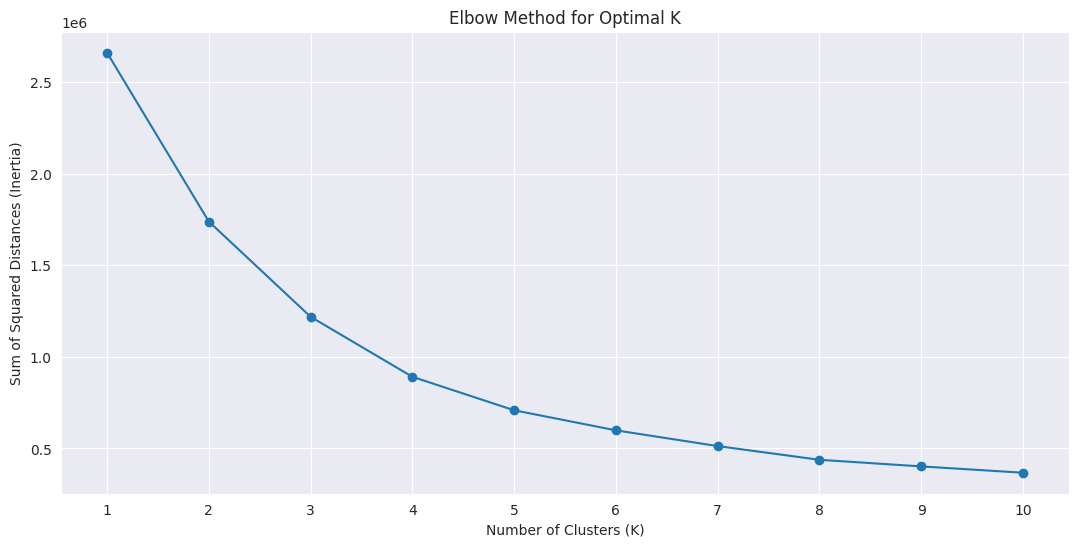

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(cleaned_train_data)

pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X)

inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(13, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.xticks(ticks=k_values)
plt.show()

In [ ]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, n_init=100, random_state=42)
kmeans.fit(X_pca)

cleaned_train_data['cluster'] = kmeans.labels_
cleaned_train_data.head()

,T,recency,duration,frequency,monetary,cluster
user_id,,,,,,
1000014,411,107,304,2,38.8500,0
1000015,411,41,370,2,40.7000,0
1000016,411,3,408,43,815.5500,0
1000019,321,42,279,5,173.9500,1
100002,503,0,503,42,1000.9500,0


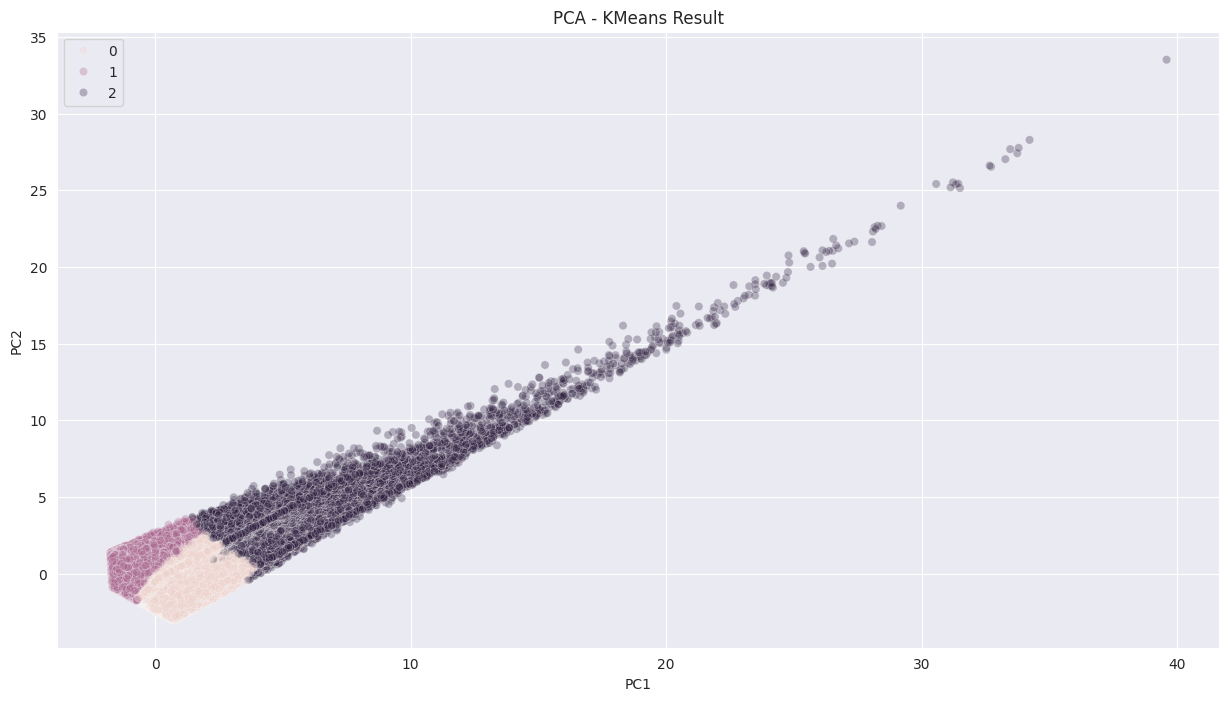

In [ ]:
plt.figure(figsize=(15, 8))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=kmeans.labels_,
    alpha=0.3
)
plt.title('PCA - KMeans Result')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='best')
plt.show()

In [ ]:
cluster_summary_funcs = {
    'T': 'mean',
    'recency': 'mean',
    'duration': 'mean',
    'monetary': 'mean',
    'frequency': 'mean'
}

cleaned_train_data.groupby('cluster').agg(cluster_summary_funcs)

,T,recency,duration,monetary,frequency
cluster,,,,,
0,413.3119,330.7627,82.5491,81.2179,3.2810
1,641.0691,452.0663,189.0028,132.2949,5.2886
2,634.7207,368.8165,265.9043,2948.0843,238.3644


In [ ]:
train_data = train_data.merge(cleaned_train_data[['cluster']], left_index=True, right_index=True, how='left')
train_data['cluster'] = train_data['cluster'].fillna(-1)
train_data.to_csv(dir_path + f'results/{customer_type}_clustering_result.csv')
train_data.to_parquet(dir_path + f'results/{customer_type}_clustering_result.snappy.parquet')

In [ ]:
train_data

,T,recency,duration,frequency,monetary,customer_type,cluster
user_id,,,,,,,
1000,682,528,154,6,100.6000,return_inactive,1
1000000,411,293,118,2,54.4000,return_inactive,0
1000004,411,406,5,2,59.4500,return_inactive,0
1000006,411,217,194,4,58.5000,return_inactive,0
1000008,411,396,15,3,40.5000,return_inactive,0
...,...,...,...,...,...,...,...
999958,410,286,124,3,44.5500,return_inactive,0
999985,411,387,24,2,55.3500,return_inactive,0
999989,411,337,74,4,88.5500,return_inactive,0


In [ ]:
one_time = pd.read_csv(dir_path + 'results/one_time_clustering_result.csv')
active_return = pd.read_csv(dir_path + 'results/return_active_clustering_result.csv')
inactive_return = pd.read_csv(dir_path + 'results/return_inactive_clustering_result.csv')

tmp_df = pd.concat([one_time, active_return, inactive_return], ignore_index=True)
tmp_df['monetary'].sum()

182419951.95000008

In [ ]:
with open(dir_path + f'results_v2/models/{customer_type}_profiling_model.pkl', 'wb') as model_file:
    pickle.dump((scaler, pca, kmeans), model_file)

In [ ]:
with open(dir_path + f'results_v2/models/{customer_type}_profiling_model.pkl', 'rb') as model_file:
    p_scaler, p_pca, p_kmeans = pickle.load(model_file)

In [ ]:
period = datetime(2023, 4, 1) + relativedelta(day=31)
print(period)
snapshot_data = data[data['last_purchase_date'] <= period][['T', 'recency', 'duration', 'frequency', 'monetary']]

In [ ]:
p_X = p_scaler.transform(snapshot_data)
p_X_pca = p_pca.transform(p_X)
labels = p_kmeans.predict(p_X_pca)
snapshot_data['cluster'] = labels

snapshot_data.to_csv(dir_path + f"results_v2/snapshots/{customer_type}/{period.strftime('%Y%m')}.csv", index=False)

In [ ]:
snapshot_data.groupby('cluster').agg(cluster_summary_funcs)